# Sentiment Analysis on Yelp Open Dataset for Review Classification

Il notebook seguente andrà ad illustrare l'intero processo per l'implementazione di un modello di Sentiment Analysis in grado di classificare le reviews in positive o negative tramite l'uso di modelli di Deep Learning.

### Import Libraries

In [60]:
# data collections
import pandas as pd
import numpy as np

# data analysis
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# text manipulation
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import nltk as nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# dataset manipulation
from collections import Counter, defaultdict
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# data modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


# save models
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/kode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading

Date le grandezze eccessive del dataset di input, si è deciso di caricare i dati al suo interno tramite la divisione in blocchi di grandezza pari a chunksize. Inoltre, tramite la documentazione fornita da Yelp, siamo stati in grado di tener conto del numero di byte da caricare grazie alla nota tipizzazione delle informazioni.

In [2]:
# definiamo i tipi degli attributi JSON per l'attributo dtype di read_json
rtypes = {  "review_id": str,
            "user_id":str,
            "business_id":str,
            "stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
            "text" : str,
           }

# file path del dataset json
path = './data/yelp_academic_dataset_review.json'

# grandezza dei chunk
chunkSize = 10000

In [3]:
%%time
# creazione del JsonReader
review = pd.read_json(path, lines=True,
                      orient="records",
                      dtype=rtypes,
                      chunksize=chunkSize)
chunkList = []

# utilizzo della segmentazione in chunk per creare dal JsonReader il dataframe
for chunkReview in review:
    # rimozione degli attributi id
    chunkReview = chunkReview.drop(['review_id', 'user_id','business_id'], axis=1)
    chunkList.append(chunkReview)
    
# concatenazione degli elementi nella chunkList per righe
df = pd.concat(chunkList, ignore_index=True, axis=0)

CPU times: user 1min 26s, sys: 14.8 s, total: 1min 41s
Wall time: 1min 41s


In [4]:
# visualizzazione degli elementi in testa
df.head()

,stars,useful,funny,cool,text,date
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


## 2. Data Analysis

Durante la fase di Data Analysis, abbiamo concentrato il nostro interesse interesse sul bilanciamento delle valutazioni relative alla colonna stars, possibili correlazioni tra le colonne numeriche secondarie (cool, funny, useful) e analisi sulle frequenze di parole e lunghezze dei testi per la colonna texts.

In [5]:
# informazioni sulle colonne del dataframe e su quante entries o righe si hanno
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   stars   float16       
 1   useful  int32         
 2   funny   int32         
 3   cool    int32         
 4   text    object        
 5   date    datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(1)
memory usage: 247.1+ MB


### 2.1 Stars Analysis

Text(0.5, 1.0, "Distribuzione dei valori per l'attributo stars")

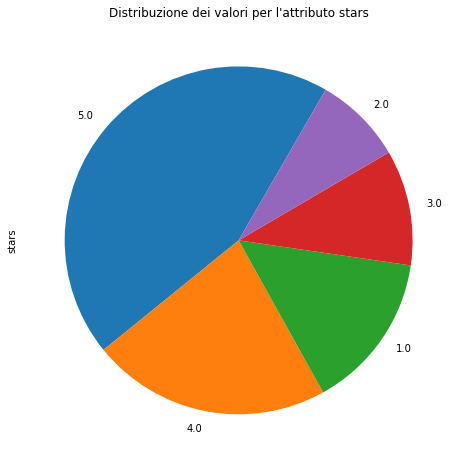

In [6]:
# definire la grandezza della figura
plt.figure(figsize=(8,8))

# contare i vari valori di stars e visualizzarli su un diagramma a torta
df['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori per l\'attributo stars')

Le quantità di recensioni, classificate in base al numero di stelle assegnate, è sbilanciata. Si ha un maggior numero per le recensioni con 5 e 4 stelle rispetto a quelle con 1, 2 o 3 stelle.

Text(0.5, 1.0, 'Distribuzione dei valori positivi e negativi')

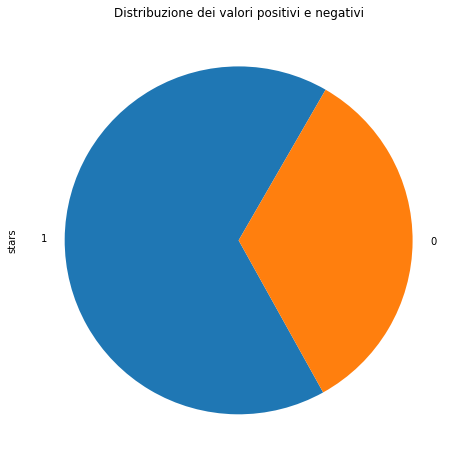

In [7]:
# distribuzione dei valori in reviews positive e negative
binstars = pd.DataFrame()
binstars['stars'] = [0 if star <= 3.0 else 1 for star in df['stars']]
# definire la grandezza della figura
plt.figure(figsize=(8,8))


# contare i vari valori di stars e visualizzarli su un diagramma a torta
binstars['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori positivi e negativi')

### 2.2 Cool, Fun and Useful Analysis

In [8]:
# Aggiunta di una feature per l'analisi della lunghezza dei testi
df['textLength']  = df['text'].str.len()

<AxesSubplot:>

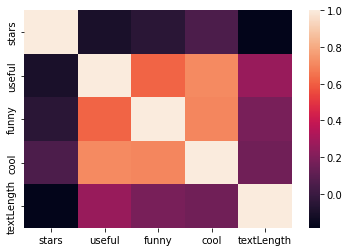

In [9]:
# definire le correlazioni
corr = df.corr()

# generazione dell'heatmap
sns.heatmap(corr)

Non sono presenti particolari correlazioni forti tra i funny, useful e cool con i valori dati a stars o text.

### 2.3 Text Analysis

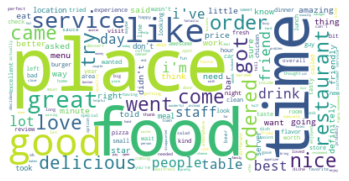

CPU times: user 20.6 s, sys: 822 ms, total: 21.4 s
Wall time: 21.4 s


In [10]:
%%time

# definisce un sottoinsieme delle righe del dataset
subset = df[:100000]
# concatenazione dei testi di ogni riga in una singola stringa
inputText = ' '.join(subset['text']).lower()

# creazione di un wordcloud andando ad ignorare le stopwords
wordCloud = WordCloud(background_color='white', stopwords=gensim.parsing.preprocessing.STOPWORDS).generate(inputText)
# setting della visualizzazione utilizzando una interpolazione bilineare
plt.imshow(wordCloud, interpolation='bilinear')

# rimozione degli assi
plt.axis('off')
# visualizzazione del wordcloud rappresentante le parole più usate nel testo di una recensione
plt.show()

Poichè la maggior parte delle recensioni fanno riferimento ad attività che forniscono servizi (ristorazione o di altro genere), l'utilizzo di parole che possano descrivere il luogo o i vari aspetti dell'attività sono quelle riscontrate con più frequenza.

In [11]:
# calcolo della frequenza dei termini più utilizzati
wordTokens = word_tokenize(inputText)
tokens = list()
for word in wordTokens:
    if word.isalpha() and word not in gensim.parsing.preprocessing.STOPWORDS:
        tokens.append(word)
tokenDist = FreqDist(tokens)
# per questioni di visualizzazione, andiamo a prendere solamente i primi 20 termini utilizzati
dist = pd.DataFrame(tokenDist.most_common(20),columns=['term', 'freq'])

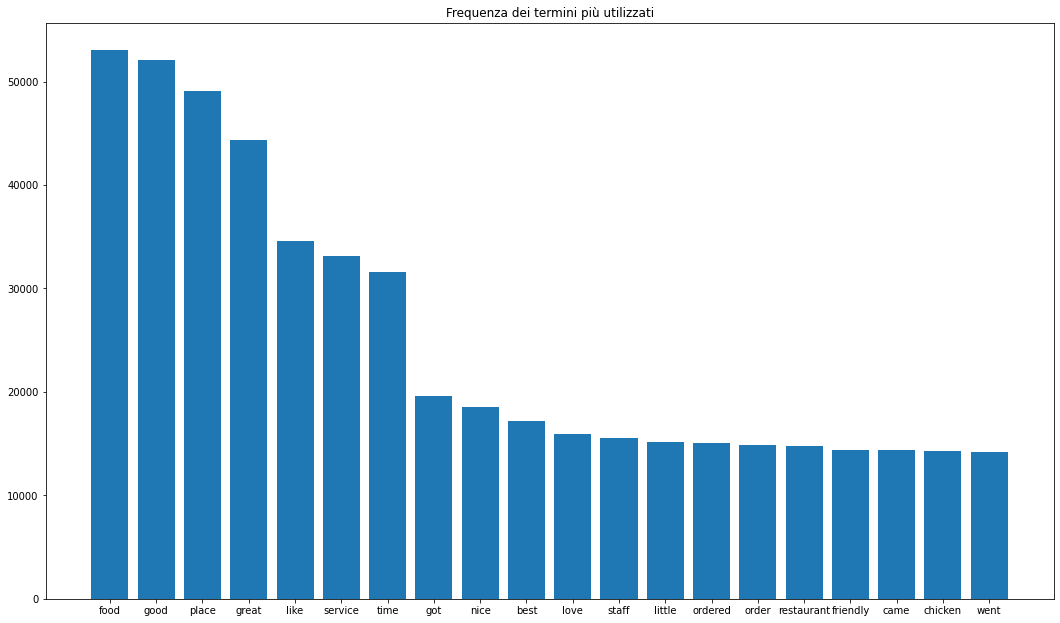

In [12]:
# rappresentazione grafica dei risultati
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x = dist['term']
y = dist['freq']
ax.bar(x,y)
plt.title('Frequenza dei termini più utilizzati')
plt.show()

Tramite il grafico delle frequenze, possiamo notare come la maggior parte delle recensioni sono di natura culinaria, ossia una descrizione del cibo che si è ordinato. Da osservare che, dato lo sbilanciamento delle valutazioni a favore delle recensioni con valutazioni maggiore, parole usate per giudizi positivi risultano con più frequenza.

In [13]:
df.head()

,stars,useful,funny,cool,text,date,textLength
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


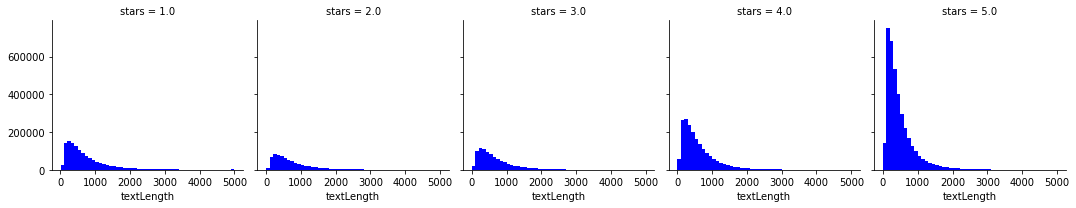

In [14]:
# Differenziazione della lunghezza dei testi in relazione alla valutazione data a stars
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'textLength',bins=50,color='blue')

## 3. Data Pre-processing

La procedura di data pre-processing sarà utilizzata per la divisione delle valutazioni secondo una classificazione binaria (stars <= 3 per review negativa, positiva altrimenti). Durante tale fase, ci siamo concentrati principalmente sulla manipolazione del testo, nello specifico abbiamo ridotto la diversificazione delle parole andando a rimuovere segni di punteggiatura, stopwords e forme alternative. Infine, abbiamo utilizzato un tokenizer in grado di poter effettuare una conversione in valori numerici (stemmizzazione) dato che, trattandosi di deep learning, il calcolo relativo alle funzioni di attivazione e del processing interno di una rete si basa esclusivamente su valori di natura numerica. 

### 3.1 Rimozione colonne inutilizzate e valori nulli

In [15]:
# cancellazione delle caratteristiche cool, funny, useful e textLength poichè non hanno correlazioni con stars.
df = df.drop(['cool', 'funny', 'useful', 'textLength'], axis=1)

In [16]:
df.head()

,stars,text,date
0,4.0,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [17]:
# rimozione di possibili testi vuoti
df['text'].dropna(inplace=True)

### 3.2 Riduzione dei testi in lowercase

In [18]:
# ridurre la forma delle parole in minuscolo
df['text'] = [review_text.lower() for review_text in df['text']]

In [19]:
df['text'].head()

0    apparently prides osteria had a rough summer a...
1    this store is pretty good. not as great as wal...
2    i called wvm on the recommendation of a couple...
3    i've stayed at many marriott and renaissance m...
4    the food is always great here. the service fro...
Name: text, dtype: object

### 3.3 Polarizzazione dei labels (stars) e bilanciamento del dataset

In [20]:
# polarizzazione delle valutazioni a stars in due categorie: 1 = positiva, 0 = negativa

# isoliamo la colonna di testo del dataframe in texts
texts =  df['text']

# andiamo ad impostare negative tutte le recensioni con 3 o meno stelle e positive quelle con 4 e 5 stelle.
stars = [0 if star <= 3.0 else 1 for star in df['stars']]

balancedTexts = [] # rappresenta la collezione di testi presi in considerazione dal dataframe di input
balancedLabels = [] # rappresenta il nuovo valore polarizzato assegnato all'entry (0,1)

# andiamo a bilanciare il dataset andando a dividere recensioni positive e negative con limite di 1.000.000 per categoria
limit = 100000  

# posizione 0 per conteggio di recensioni negative, posizione 1 per quelle positive
negPosCounts = [0, 0] 

for i in range(0,len(texts)):
    polarity = stars[i]
    if negPosCounts[polarity] < limit: # se non si è raggiunto il limite per la categoria di polarizzazione
        balancedTexts.append(texts[i])
        balancedLabels.append(stars[i])
        negPosCounts[polarity] += 1

In [21]:
df_balanced = pd.DataFrame()
df_balanced['text'] = balancedTexts
df_balanced['labels'] = balancedLabels
df_balanced.head()

,text,labels
0,apparently prides osteria had a rough summer a...,1
1,this store is pretty good. not as great as wal...,1
2,i called wvm on the recommendation of a couple...,1
3,i've stayed at many marriott and renaissance m...,0
4,the food is always great here. the service fro...,1


In [22]:
# verifica del conteggio
counter = Counter(df_balanced['labels'])
print(f'Ci sono {counter[1]} recensioni positive e {counter[0]} recensioni negative')

Ci sono 100000 recensioni positive e 100000 recensioni negative


### 3.3 Lemmatizzazione

In [23]:
%%time
# creazione del lemmatizer
lemmatizer = WordNetLemmatizer()

# funzione per l'aggiunta del tag semantico che evidenzia il tipo di parola da dover selezionare
def word_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


# elaborazione sui testi del dataset
texts = df_balanced['text']
df_texts = []
for text in texts:
    # tokenizzazione del text per l'aggiunta dei tag
    word_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    # mapping parole:tag del testo analizzato
    map_word_tag = list(map(lambda x: (x[0], word_tagger(x[1])), word_tagged))
    # costruzione del testo lemmatizzato
    lemmatized_text = []
    for word, tag in map_word_tag:
        if tag is None:
            # elemento non tokenizzabile
            lemmatized_text.append(word)
        else:
            # lemmmatizzazione della parola in relazione al 
            # tipo di elemento
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    # aggiunta della parola post-lemmatizzazione al testo selezionato
    lemmatized_text = " ".join(lemmatized_text)
    # aggiunta del testo nella collezione dei testi lemmatizzati
    df_texts.append(lemmatized_text)

print(texts[0] + "\n\n")
print(df_texts[0])

apparently prides osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a friday night. however new blood in the kitchen seems to have revitalized the food from other customers recent visits. waitstaff was warm but unobtrusive. by 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. perhaps beverly residents prefer a later seating. 

after reading the mixed reviews of late i was a little tentative over our choice but luckily there was nothing to worry about in the food department. we started with the fried dough, burrata and prosciutto which were all lovely. then although they don't offer half portions of pasta we each ordered the entree size and split them. we chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and grana frita. both were very good. we split a secondi which was the special berkshire pork secreto, which was described as a pork skirt steak with g

In [24]:
df_balanced['text'] = df_texts

### 3.4 Rimozione delle stop words e di caratteri non alfanumerici

In [25]:
# Stop words da rimuovere
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'might', 'never', 'whenever', 'bill', 'due', 'beside', 'too', 'call', 'at', 'cry', 'had', 'himself', 'namely', 'mostly', 'seemed', 'now', 'hers', 'still', 'hence', 'nowhere', 'was', 'first', 'unless', 'detail', 'five', 'thus', 'thin', 'next', 'find', 'yourselves', 'hereby', 'same', 'twelve', 'couldnt', 'that', 'perhaps', 'yet', 'co', 'less', 'with', 'we', 'fill', 'con', 'whereupon', 'again', 'see', 'otherwise', 'under', 'really', 'they', 'afterwards', 'is', 'moreover', 'amoungst', 'because', 'by', 'each', 'found', 'hasnt', 'only', 'top', 'mill', 'just', 'when', 'keep', 'inc', 'nor', 'become', 'do', 'also', 'myself', 'ever', 'former', 'whatever', 'while', 'hereupon', 'move', 'something', 'am', 'using', 'further', 'fifty', 'has', 'ltd', 'must', 'two', 'against', 'any', 'meanwhile', 'ie', 'her', 'another', 'show', 'those', 'up', 'what', 'etc', 'are', 'latter', 'not', 'done', 'whither', 'name', 'front', 'among', 'three', 'you', 'an', 'own', 'been', 'or', 'where', 'amount', 'some

In [26]:
# Rimozione delle stop words
df_texts = []
for text in df_balanced['text']:
    df_texts.append(remove_stopwords(text))

df_balanced['text'] = df_texts

# Rimozione dei caratteri non alfanumerici
df_texts = []
for text in df_balanced['text']:
    df_texts.append(''.join(ch for ch in text if ch.isalnum() or ch == ' '))

df_balanced['text'] = df_texts

In [27]:
print(df_balanced['text'])

0         apparently pride osteria rough summer evidence...
1         store pretty good  great walmart  preferred  m...
2         wvm recommendation couple friend use past thin...
3         ve stay marriott renaissance marriott s huge d...
4         food great  service manager staff super  draw ...
                                ...                        
199995    s okay place  crowd friday saturday  music mix...
199996    order wing  fry website  account use   wait ho...
199997    location easy  din area small  customer servic...
199998    m realtor client year pretty happy service yea...
199999     place specialize fish taco  dull fish taco  wtf 
Name: text, Length: 200000, dtype: object


### 3.5 Text Tokenization

In [28]:
%%time
# tokenizzazione del testo andando a dividere le stringhe in una lista di lemmi
df_balanced['text'] = [nltk.word_tokenize(text) for text in df_balanced['text']]

CPU times: user 43.6 s, sys: 2.2 s, total: 45.8 s
Wall time: 47.5 s


### 3.6 Preparazione Dati Vettoriali per la Fase di Modelling

In [29]:
# definire il numero di parole da passare all'oggetto Tokenizer
# bisogna analizzare la quantità di parole che si ha nel dataframe selezionato
map_terms = dict()
for text in df_balanced['text']:
    for word in text:
        if word not in map_terms:
            map_terms[word] = 1

print(f'There are {len(map_terms)} different words') # number of words

There are 132062 different words


In [46]:
%%time
# definizione di un tokenizer delle prime 10.000 parole più utilizzate
tokenizer = Tokenizer(num_words=13206)
tokenizer.fit_on_texts(df_balanced['text'])
# trasformazione della sequenza di lemmi in sequenze di interi in modo da valutare più velocemente le parole
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
# Sequenze di massimo 200 unità. Se vi sono testi con sequenze più lunghe esse vengono troncate, altrimenti si avrà 
# un riempimenti di 0 per testi undersized.
text_sequence = pad_sequences(sequences, maxlen=200)
labels = np.array(df_balanced['labels'])

CPU times: user 11.5 s, sys: 138 ms, total: 11.6 s
Wall time: 11.7 s


In [47]:
# check parziale degli indici delle parole 
word_index = tokenizer.word_index
# prendiamo le prime 50 parole indicizzate
check = {key: value for key, value in word_index.items() if value <= 50}
print(check)

{'nt': 1, 's': 2, 'good': 3, 'food': 4, 'place': 5, 'time': 6, 'like': 7, 'great': 8, 'order': 9, 'come': 10, 'service': 11, 'try': 12, 've': 13, 'wait': 14, 'look': 15, 'restaurant': 16, 'want': 17, 'nice': 18, 'm': 19, 'love': 20, 'price': 21, 'ask': 22, 'know': 23, 'think': 24, 'eat': 25, 'tell': 26, 'staff': 27, 'day': 28, 'people': 29, 'little': 30, 'best': 31, 'drink': 32, 'experience': 33, 'chicken': 34, 'bad': 35, 'work': 36, 'table': 37, 'thing': 38, 'menu': 39, 'pretty': 40, 'minute': 41, 'need': 42, 'friendly': 43, 'taste': 44, 'way': 45, 'definitely': 46, 'friend': 47, 'bar': 48, 'night': 49, 'delicious': 50}


Il vettore dei valori numerici ha un dominio pari a 20.000 parole differenti tra le 132.062 parole totali. Si andrà, quindi, a selezionare 1/6 delle parole presenti nelle reviews che, però, ha una rilevanza maggiore rispetto ai 5/6 restanti poichè hanno occorrenze maggiori. Inoltre, la sequenza ordinata creata andrà a seguire l'ordine di occorenza dei termini all'interno dei testi di 300 parole (grandezza massima).

## 4. Modelling

In questa fase è possibile trovare modelli alternativi utilizzati oggigiorno nel campo NLP. Nello specifico, si propone una triplice alternativa che vede l'utilizzo di un modello basato su LSTM, un modello di convulational neural network che va a supporto di LSTM e, infine, un modello di LSTM bidirezionale. Possiamo affermare che tutti i modelli hanno raggiunto un livello di precisione accettabile; ciò non toglie che vi possano essere vari miglioramenti che possano incrementarne le prestazioni.

In [48]:
# checking sulle compile flags di tensorflow
print(tf.sysconfig.get_compile_flags())
print(tf.__version__)

['-I/usr/local/lib/python3.9/site-packages/tensorflow/include', '-D_GLIBCXX_USE_CXX11_ABI=0', '-DEIGEN_MAX_ALIGN_BYTES=64']
2.6.0


In [140]:
# gestione del callbacks
# creazione del F-Score sul validation e training set
class F1History(tf.keras.callbacks.Callback):

    def __init__(self, train, validation=None):
        super(F1History, self).__init__()
        self.validation = validation
        self.train = train

    # stampa dei valori di F1-Score alla fine di ogni epoch
    def on_epoch_end(self, epoch, logs={}):

        logs['f1_score_train'] = float('-inf')
        X_train, y_train = self.train[0], self.train[1]
        y_pred = (self.model.predict(X_train).ravel()>0.5)+0

        if (self.validation):
            logs['f1_score_val'] = float('-inf')
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_val_pred = (self.model.predict(X_valid).ravel()>0.5)+0
            val_score = f1_score(y_valid, y_val_pred)
            logs['f1_score_train'] = np.round(score, 5)
            logs['f1_score_val'] = np.round(val_score, 5)
        else:
            logs['f1_score_train'] = np.round(score, 5)

In [114]:
# early stopping
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [96]:
# train and test splitting
x_train, x_test, y_train, y_test = train_test_split(text_sequence , labels ,random_state=520, test_size=0.33, shuffle=True)

# train and validation splitting
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.33, random_state=1)

In [97]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

89780
44220
66000


### 4.1 Modello basato su LSTM

In [111]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
model_lstm = keras.Sequential()

# aggiunta dei layers
model_lstm.add(layers.Embedding(13206, 64, 
                                input_length=200))
model_lstm.add(layers.Dropout(0.4))
model_lstm.add(layers.LSTM(64, 
                           dropout=0.2, 
                           recurrent_dropout=0.2));
model_lstm.add(layers.Dropout(0.4))
model_lstm.add(layers.Dense(1, activation='sigmoid'));

model_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 64)           845184    
_________________________________________________________________
dropout_24 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 878,273
Trainable params: 878,273
Non-trainable params: 0
_________________________________________________________________


In [112]:
results_lstm = model_lstm.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val), callbacks=[F1History(train=(x_train,y_train),validation=(x_val,y_val)), es_callback])

Epoch 1/3
2806/2806 [==============================] - 504s 179ms/step - loss: 0.3589 - accuracy: 0.8455 - val_loss: 0.3042 - val_accuracy: 0.8689
Epoch 2/3
2806/2806 [==============================] - 474s 169ms/step - loss: 0.2921 - accuracy: 0.8782 - val_loss: 0.3027 - val_accuracy: 0.8707
Epoch 3/3
2806/2806 [==============================] - 513s 183ms/step - loss: 0.2643 - accuracy: 0.8901 - val_loss: 0.2985 - val_accuracy: 0.8690


In [115]:
model_lstm.evaluate(x_test, y_test)

2063/2063 [==============================] - 34s 16ms/step - loss: 0.3068 - accuracy: 0.8669


[0.30677175521850586, 0.8669090867042542]

modelLSTM.evaluate(xTest, yTest)

### 4.2 Modello basato su CNN

In [100]:
model_cnn = keras.Sequential()
model_cnn.add(layers.Embedding(13206, 64, input_length=200)) #layer iniziali 
model_cnn.add(layers.Dropout(0.4)) # layer di dropout esterno in seguito ad Embedding
model_cnn.add(layers.Conv1D(64,
                        4,
                        activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=4))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dropout(0.4))
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dropout(0.4))
model_cnn.add(layers.Dense(1, activation='sigmoid'))


model_cnn.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])



model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 64)           845184    
_________________________________________________________________
dropout_19 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 197, 64)           16448     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 3136)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

In [104]:
results_cnn = model_cnn.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val), callbacks=[F1History(train=(x_train,y_train),validation=(x_val,y_val)), es_callback])

Epoch 1/3
2806/2806 [==============================] - 56s 20ms/step - loss: 0.1876 - accuracy: 0.9234 - val_loss: 0.3693 - val_accuracy: 0.8605
Epoch 2/3
2806/2806 [==============================] - 56s 20ms/step - loss: 0.1713 - accuracy: 0.9307 - val_loss: 0.4060 - val_accuracy: 0.8566
Epoch 3/3
2806/2806 [==============================] - 56s 20ms/step - loss: 0.1578 - accuracy: 0.9351 - val_loss: 0.4492 - val_accuracy: 0.8539


In [105]:
model_cnn.evaluate(x_test, y_test)

2063/2063 [==============================] - 4s 2ms/step - loss: 0.4535 - accuracy: 0.8520


[0.45354142785072327, 0.8520151376724243]

### 4.1.1 Modello basato CNN + LSTM

In [117]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
model_lstm = keras.Sequential()

# aggiunta dei layers
model_lstm.add(layers.Embedding(13206, 64, input_length=200))
model_lstm.add(layers.Dropout(0.25)) 
model_lstm.add(layers.Conv1D(64, 
                             4, 
                             activation='relu'))
model_lstm.add(layers.MaxPooling1D(pool_size=4))
model_lstm.add(layers.Dropout(0.4))
model_lstm.add(layers.LSTM(64));
model_lstm.add(layers.Dropout(0.4)) 
model_lstm.add(layers.Dense(1, activation='sigmoid')); 

model_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 64)           845184    
_________________________________________________________________
dropout_29 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 197, 64)           16448     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 49, 64)            0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 49, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)              

In [119]:
results_lstm = model_lstm.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=3, callbacks=[F1History(train=(x_train,y_train),validation=(x_val,y_val))])

Epoch 1/3
2806/2806 [==============================] - 97s 34ms/step - loss: 0.3557 - accuracy: 0.8429 - val_loss: 0.3036 - val_accuracy: 0.8692
Epoch 2/3
2806/2806 [==============================] - 98s 35ms/step - loss: 0.2823 - accuracy: 0.8825 - val_loss: 0.3027 - val_accuracy: 0.8700
Epoch 3/3
2806/2806 [==============================] - 92s 33ms/step - loss: 0.2437 - accuracy: 0.8996 - val_loss: 0.3112 - val_accuracy: 0.8656


In [120]:
model_lstm.evaluate(x_test, y_test)

2063/2063 [==============================] - 10s 5ms/step - loss: 0.3150 - accuracy: 0.8640


[0.3149608075618744, 0.8639545440673828]

### 4.3 Modello CNN + biLSTM

In [121]:
model_bid = keras.Sequential()
model_bid.add(layers.Embedding(13206, 64, input_length=200))
model_bid.add(layers.Dropout(0.4))
model_bid.add(layers.Conv1D(64,
                        4,
                        activation='relu'))
model_bid.add(layers.MaxPooling1D(pool_size=4))
model_bid.add(layers.Dropout(0.4))
model_bid.add(layers.Bidirectional(layers.LSTM(128)))
model_bid.add(layers.Dropout(0.4))
model_bid.add(layers.Dense(1, activation='sigmoid'))
model_bid.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_bid.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 64)           845184    
_________________________________________________________________
dropout_32 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 197, 64)           16448     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 49, 64)            0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 49, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)             

In [122]:
results_bid = model_bid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, callbacks=[F1History(train=(x_train,y_train),validation=(x_val,y_val)), es_callback])

Epoch 1/3
2806/2806 [==============================] - 168s 59ms/step - loss: 0.3552 - accuracy: 0.8428 - val_loss: 0.3043 - val_accuracy: 0.8680
Epoch 2/3
2806/2806 [==============================] - 166s 59ms/step - loss: 0.2892 - accuracy: 0.8779 - val_loss: 0.2981 - val_accuracy: 0.8711
Epoch 3/3
2806/2806 [==============================] - 165s 59ms/step - loss: 0.2581 - accuracy: 0.8920 - val_loss: 0.3112 - val_accuracy: 0.8684


In [123]:
model_bid.evaluate(x_test,y_test)

2063/2063 [==============================] - 28s 14ms/step - loss: 0.3182 - accuracy: 0.8658


[0.31822991371154785, 0.8657575845718384]

## 5. Save Models

Data l'eccessiva tempo speso per l'addestramento delle reti neurali proposte, abbiamo deciso di salvare tramite la libreria pickle le componenti e i modelli addestrati in modo da poterli rendere disponibili per l'analisi delle prestazioni e l'utilizzo.

In [126]:
import pickle

# salviamo il tokenizer e i modelli su file
with open("dump/keras_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)
    
model_lstm.save("dump/model/yelp_model_lstm.hdf5")
model_cnn.save("dump/model/yelp_model_cnn.hdf5")
model_bid.save("dump/model/yelp_bidirectional_lstm.hdf5")


In [130]:
# carichiamo il tokenizer e il modello da file
with open("dump/keras_tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

# TODO: load other models
model_lstm = load_model("dump/model/yelp_model_lstm.hdf5")
model_cnn = load_model("dump/model/yelp_model_cnn.hdf5")
model_bid = load_model("dump/model/yelp_bidirectional_lstm.hdf5")

# definiamo gli esempi su cui testare il modello
examples_reviews = ["slow orders but good food", "Delicious foods! Awesome!", "Bad food, bad people... horrible!"]

# usiamo il tokenizer per creare sequenze di interi da dare al modello
sequences = tokenizer.texts_to_sequences(examples_reviews)
data_examples = pad_sequences(sequences, maxlen=200)

# effettuare le predizioni e stampare i risultati
predictions_lstm = model_lstm.predict(data_examples)
predictions_cnn = model_cnn.predict(data_examples)
predictions_bid = model_bid.predict(data_examples)
predictions_bid_lstm = model_bid_lstm.predict(data_examples)

print(f"Risultati modello CNN:\n {predictions_cnn}\n\n" + 
    f"Risultati modello CNN+LSTM:\n {predictions_lstm}\n\n"+
      f"Risultati modello CNN+biLSTM:\n {predictions_bid})

Risultati modello LSTM:
 [[0.05765709]
 [0.89711237]
 [0.04066032]]

Risultati modello CNN:
 [[0.0697552 ]
 [0.88013995]
 [0.01199266]]

Risultati modello biLSTM:
 [[0.03416514]
 [0.93249893]
 [0.01644477]]

Risultati modello combinato biLSTM + LSTM:
 [[0.05569908]
 [0.90850663]
 [0.01964512]]


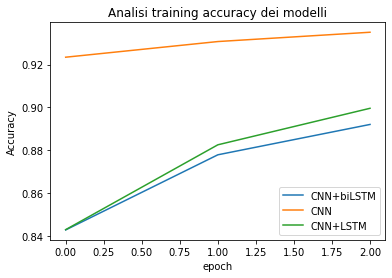

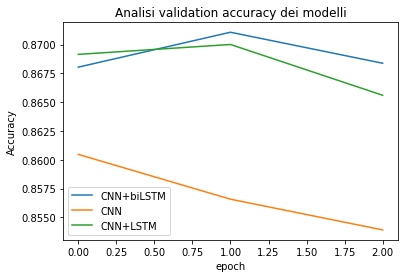

In [144]:
# grafico di paragone per i valori della training accuracy tra i modelli proposti
plt.plot(results_bid.history['accuracy'])
plt.plot(results_cnn.history['accuracy'])
plt.plot(results_lstm.history['accuracy'])
plt.title('Analisi training accuracy dei modelli')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['CNN+biLSTM', 'CNN', 'CNN+LSTM', 'CNN+biLSTM+LSTM'], loc='best')
plt.show()


# grafico di paragone per i valori dell'accuracy in validazione
plt.plot(results_bid.history['val_accuracy'])
plt.plot(results_cnn.history['val_accuracy'])
plt.plot(results_lstm.history['val_accuracy'])
plt.title('Analisi validation accuracy dei modelli')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['CNN+biLSTM', 'CNN', 'CNN+LSTM'], loc='best')
plt.show()

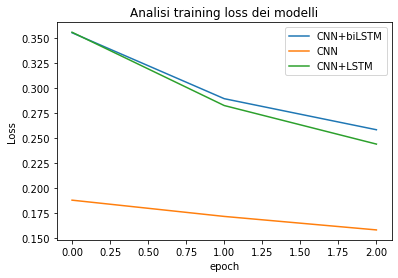

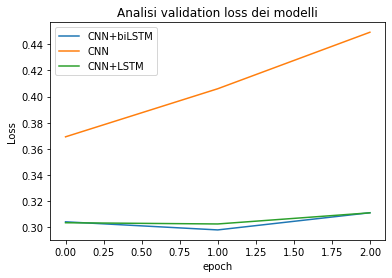

In [145]:
# grafico di paragone per i valori della loss function tra i modelli proposti
plt.plot(results_bid.history['loss'])
plt.plot(results_cnn.history['loss'])
plt.plot(results_lstm.history['loss'])
plt.title('Analisi training loss dei modelli')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['CNN+biLSTM', 'CNN', 'CNN+LSTM'], loc='best')
plt.show()

# grafico di paragone per i valori della loss function tra i modelli proposti
plt.plot(results_bid.history['val_loss'])
plt.plot(results_cnn.history['val_loss'])
plt.plot(results_lstm.history['val_loss'])
plt.title('Analisi validation loss dei modelli')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['CNN+biLSTM', 'CNN', 'CNN+LSTM'], loc='best')
plt.show()

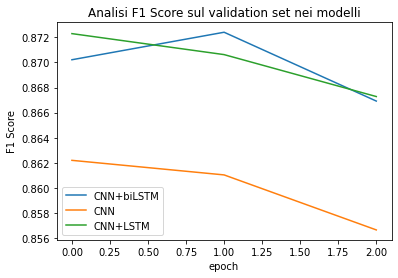

In [142]:
# grafico di paragone per i valori del F1-Score in validation
plt.plot(results_bid.history['F1_score_val'])
plt.plot(results_cnn.history['F1_score_val'])
plt.plot(results_lstm.history['F1_score_val'])
plt.title('Analisi F1 Score sul validation set nei modelli')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['CNN+biLSTM', 'CNN', 'CNN+LSTM'], loc='best')
plt.show()